   frame  subframe                                IVD    P  SC  N   RC
0   1026         2  [174.77, 150.87, 284.38, 1827.13]  0.8  62  5  515
1   1026        10                          [2057.51]  0.8  70  2  515
2   1027         1                    [187.71, 348.3]  0.8  71  3  515
3   1027         3                  [1221.05, 734.65]  0.8  73  3  515
4   1027         4                          [3246.62]  0.8  74  2  515


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


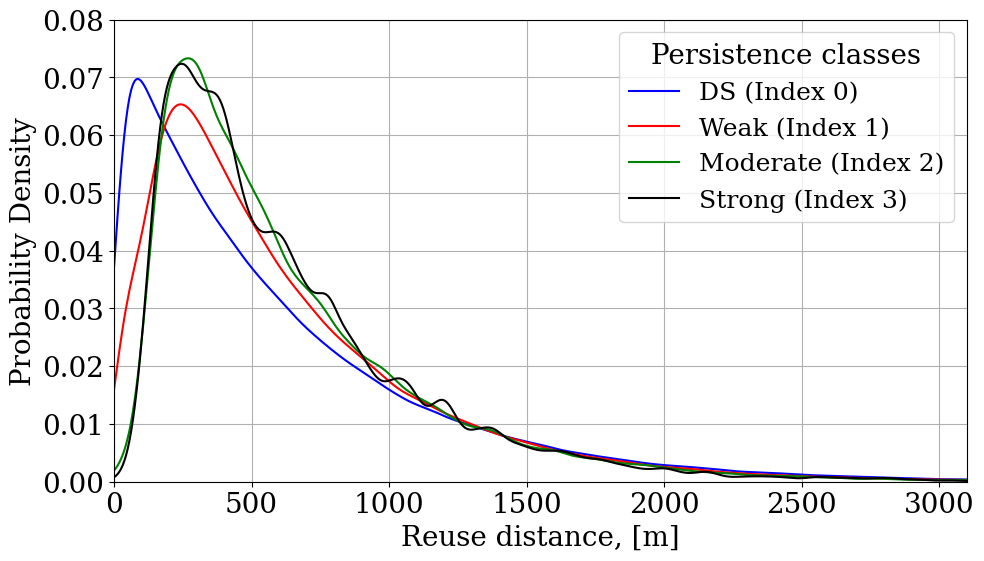

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

density = 700

# Load the CSV data
df_PDF = pd.read_csv(f"pp/{density}_PDF.csv", names=['frame', 'subframe', 'IVD', 'P', 'SC', 'N', 'RC'])

# Preprocess the IVD column to handle bracketed, space-separated float arrays
df_PDF['IVD'] = df_PDF['IVD'].apply(
    lambda x: np.array([float(num) for num in x.strip('[]').split()]) if isinstance(x, str) else np.array(x)
)

print(df_PDF.head())

# Filtering combinations
combinations = [
    {"RC": 1, "P": 0.00, "label": "DS (Index 0)"},
    {"RC": 1, "P": 0.50, "label": "Weak (Index 1)"},
    {"RC": 1, "P": 0.95, "label": "Moderate (Index 2)"},
    {"RC": 1, "P": 0.995, "label": "Strong (Index 3)"}
]
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20  # Set the default font size for all text in the figure
plt.rcParams['legend.fontsize'] = '18'  # Set the legend font size
# Set up figure for KDE curves
kde_fig, kde_ax = plt.subplots(figsize=(11, 6))


# Colors for different combinations
colors = ['blue', 'red', 'green', 'black']

# Number of markers to display on each curve
num_markers_to_display = 20

# Loop through the combinations
for idx, combo in enumerate(combinations):
    # Filter the dataframe based on RC and P values
    filtered_df = df_PDF[(df_PDF['RC'] == combo["RC"]) & (df_PDF['P'] == combo["P"])]
    
    if not filtered_df.empty:
        # Concatenate all arrays in IVD column
        yv = np.concatenate(filtered_df['IVD'].values)
    else:
        continue  # Skip if no matching data

    # Apply Kernel Density Estimation (KDE)
    kde = gaussian_kde(yv, bw_method='silverman')
    x_vals = np.linspace(0, 3100, 500)  # Generate a range of values for KDE
    kde_vals = kde(x_vals)

    # Select a subset of markers to display
    marker_indices = np.linspace(0, len(x_vals) - 1, num_markers_to_display).astype(int)
    markers_on_x = x_vals[marker_indices]
    markers_on_y = kde_vals[marker_indices]

    # Plot the KDE curve
    color = colors[idx]
    kde_ax.plot(x_vals, kde_vals*50, label=f'{combo["label"]}', color=color)
    
    # Plot only the selected markers
    #kde_ax.scatter(markers_on_x, markers_on_y, color=color, marker='s', facecolors='none', zorder=3)

# Customize plot
kde_ax.set_xlabel('Reuse distance, [m]', fontsize = 20)
kde_ax.set_ylabel('Probability Density', fontsize = 20)
kde_ax.grid(True)
kde_ax.set_xlim(0, 3100)
kde_ax.set_ylim(0, 0.08)
kde_ax.legend(title='Persistence classes')

# Save figure
kde_fig.savefig('PDF_hist.eps', format='eps')

plt.show()


In [13]:
import pandas as pd
import numpy as np
from scipy.io import savemat
import os
from multiprocessing import Pool

density = 700

def optimized_fill_all_gaps(df):
    df['int_div_10_24'] = (df['time'] // 10.24).astype(int)

    df['diffF'] = (df['nextF'] - df['timeF']) % 1024
    df['nextF'] = df['int_div_10_24'] * 1024 + df['nextF']
    df['timeF'] = df['int_div_10_24'] * 1024 + df['timeF']

    new_rows = []

    for node_id, group in df.groupby('nodeID'):
        group = group.sort_values(by='timeF')
        raw_f_list = group['timeF'].tolist()
        raw_f_list.append(10100)  # max_frame

        for i in range(len(raw_f_list) - 1):
            df_filtered = group[group['timeF'] == raw_f_list[i]]

            for row_time in range(int(raw_f_list[i] + 10), int(raw_f_list[i + 1]), 10):
                new_rows.append({
                    'nodeID': node_id,
                    'time': df_filtered['time'].iloc[0],
                    'timeF': row_time,
                    'timeSF': df_filtered['timeSF'].iloc[0],
                    'RC': -1,
                    'nextF': df_filtered['diffF'].iloc[0] + row_time,
                    'nextSF': df_filtered['nextSF'].iloc[0],
                    'int_div_10_24': -1
                })

    return pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True)

def process_parameter(var_parameter, RC):
    df = pd.read_csv(
        f'n{density}/baoicchi_mob_veh_{density}_pKeep_{var_parameter}_ReEval1_RC{RC}/SSPSlog.txt',
        usecols=[0, 1, 2, 3, 9, 16, 17],
        names=["nodeID", "time", "timeF", "timeSF", "RC", "nextF", "nextSF"]
    )
    df_extended = optimized_fill_all_gaps(df)

    df_pos = pd.read_csv(
        f'n{density}/baoicchi_mob_veh_{density}_pKeep_{var_parameter}_ReEval1_RC{RC}/LogPOS.txt',
        usecols=[0, 1, 2],
        names=['nodeID', 'X', 'Y']
    ).drop_duplicates(subset='nodeID').sort_values(by='nodeID')

    df_pos['nodeID'] += 1
    merged_df = pd.merge(df_extended, df_pos, on='nodeID', how='left')

    df_filtered = merged_df[(merged_df['timeF'] < 10100)]

    new_time_rows = [
        {
            'time': (frame * 10 + subframe) / 1000,
            'nodes': df_filtered[(df_filtered['nextF'] == frame) & (df_filtered['nextSF'] == subframe)].shape[0],
            'pkeep': var_parameter,
            'SC': subframe + (frame % 10) * 10
        }
        for frame in range(1, 10100)
        for subframe in range(1, 11)
    ]

    df_time_order = pd.DataFrame(new_time_rows)
    df_time_order.to_csv(f"pp/{density}_time_order_{RC}.csv", mode='a', header=False, index=False)

if __name__ == "__main__":
    RC = 515
    #parameter_range = ['0.000000', '0.100000', '0.200000', '0.300000', '0.400000', '0.500000', '0.600000', '0.700000', '0.800000', '0.900000', '0.950000', '0.975000', '0.983333', '0.987500', '0.990000', '0.993333', '0.995000']
    parameter_range = ['0.000000', '0.100000', '0.200000', '0.300000', '0.400000', '0.500000', '0.600000', '0.700000', '0.800000']

    with Pool() as pool:
        pool.starmap(process_parameter, [(var, RC) for var in parameter_range])


In [14]:
##### TIME DIMENSION ANALYSIS - COV

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#parameter_range = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975, 0.983333, 0.987500, 0.99, 0.993333, 0.995000]
parameter_range = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

COV_list = []

mean_SC_list = []

density=700



RC=515

df_time_order_raw = pd.read_csv(f'pp/{density}_time_order_{RC}.csv', names=['time', 'nodes', 'pkeep', 'SC'])

df_time_order = df_time_order_raw

for var_parameter in parameter_range:

    for sc in range(1,101):
        filter_df = df_time_order[(df_time_order['pkeep']==var_parameter) & (df_time_order['SC']==sc)]
        # Compute Mean Reuse Distance
        mean_nodes = filter_df['nodes'].mean()

        # Compute Standard Deviation of Reuse Distance
        std_nodes = filter_df['nodes'].std()

        # Compute Coefficient of Variation (COV)
        COV = std_nodes / mean_nodes

        COV_list.append({'RC': RC, 'pkeep': var_parameter, 'mean_nodes': mean_nodes, 'std_nodes': std_nodes, 'COV': COV, 'SC':sc})

COV_df = pd.DataFrame(COV_list)

COV_df.to_csv(f'pp/{density}_COV_time.csv', mode='a', header=False, index=False)


for var_parameter in parameter_range:

    mean_N = COV_df[COV_df['pkeep']==var_parameter]['mean_nodes'].mean()
    mean_std = COV_df[COV_df['pkeep']==var_parameter]['std_nodes'].mean()
    mean_COV = COV_df[COV_df['pkeep']==var_parameter]['COV'].mean()
    if RC == 515:
        eta = 10/(1-var_parameter)
    else:
        eta = 1/(1-var_parameter)
    mean_SC_list.append({'RC': RC, 'pkeep': var_parameter, 'mean_nodes': mean_N, 'std_nodes': mean_std, 'COV': mean_COV, 'eta': eta})


mean_COV_df = pd.DataFrame(mean_SC_list)

mean_COV_df.to_csv(f'pp/{density}_mean_COV_time.csv', mode='a', header=False, index=False)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


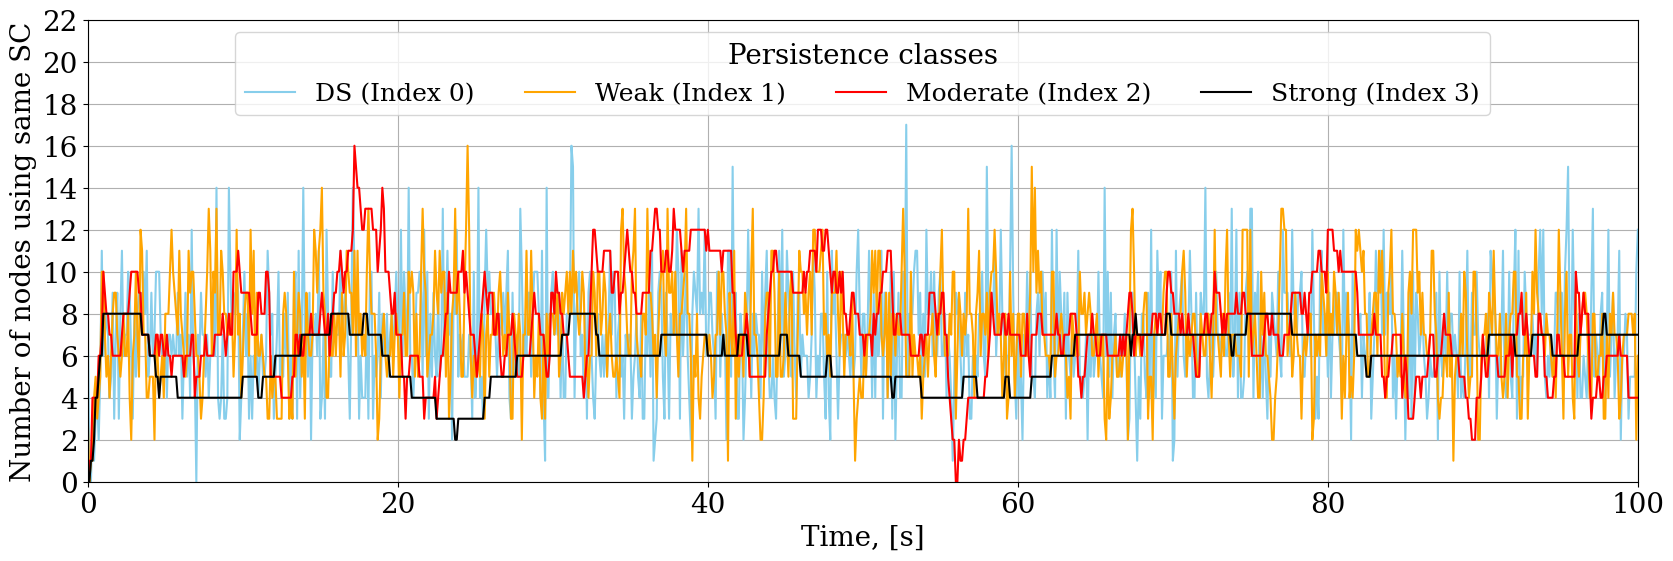

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

density = 700

# Reading the CSV files
df_time_order1 = pd.read_csv(f'pp/{density}_time_order_1.csv', names=['time', 'nodes', 'pkeep', 'SC'])
df_time_order2 = pd.read_csv(f'pp/{density}_time_order_1.csv', names=['time', 'nodes', 'pkeep', 'SC'])

labels = ['DS (Index 0)', 'Weak (Index 1)', 'Moderate (Index 2)', 'Strong (Index 3)']

# Filtering the data
filtered_df1 = df_time_order1[(df_time_order1['pkeep'].isin([0.00, 0.50])) & (df_time_order1['SC'] == 20)]
filtered_df2 = df_time_order2[(df_time_order2['pkeep'].isin([0.95, 0.995])) & (df_time_order2['SC'] == 20)]

# Plotting
plt.figure(figsize=(20, 6))

# Plot for df_time_order1 with pkeep=0.00 and pkeep=0.50
for i, (pkeep, group) in enumerate(filtered_df1.groupby('pkeep')):
    color = 'skyblue' if pkeep == 0.00 else 'orange'
    plt.plot(group['time'], group['nodes'], label=labels[i], color=color)


# Plot for df_time_order2 with pkeep=0.95 and pkeep=0.995
for i, (pkeep, group) in enumerate(filtered_df2.groupby('pkeep'), start=2):  # Start index from 2 for second set of labels
    color = 'red' if pkeep == 0.95 else 'black'
    plt.plot(group['time'], group['nodes'], label=labels[i], color=color)

    

# Adding labels and title
plt.xlabel('Time, [s]')
plt.ylabel('Number of nodes using same SC')

# Set x and y limits
plt.xlim(0, 100)
plt.ylim(0, 22)

# Set y-axis ticks from 0 to 20 with a step of 1
plt.yticks(np.arange(0, 23, 2))

# Adding grid and legend
plt.grid(True)
plt.legend(ncols=4, loc='upper center', title='Persistence classes')

# Save the figure
plt.savefig(f"figures/{density}_SC_time_evolution.eps", format='eps')

# Show the plot
plt.show()


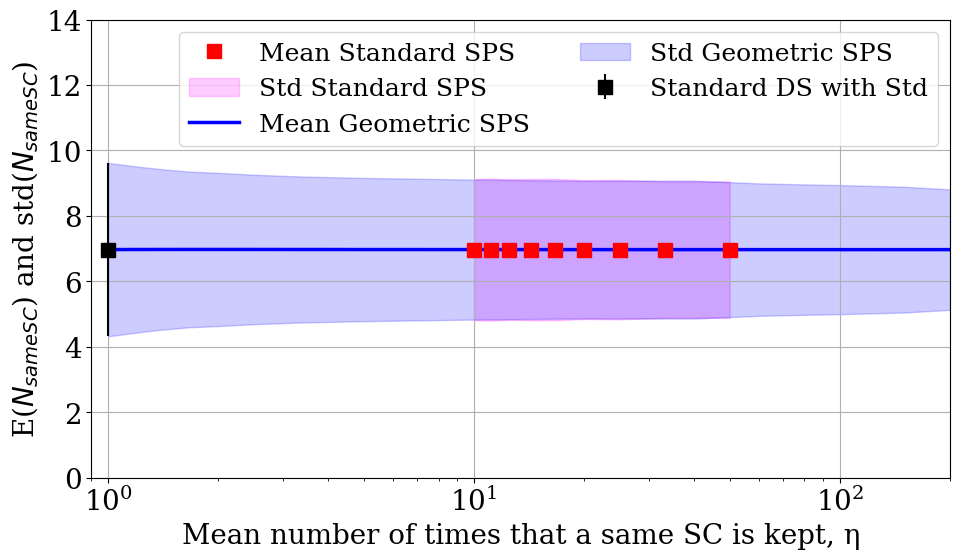

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


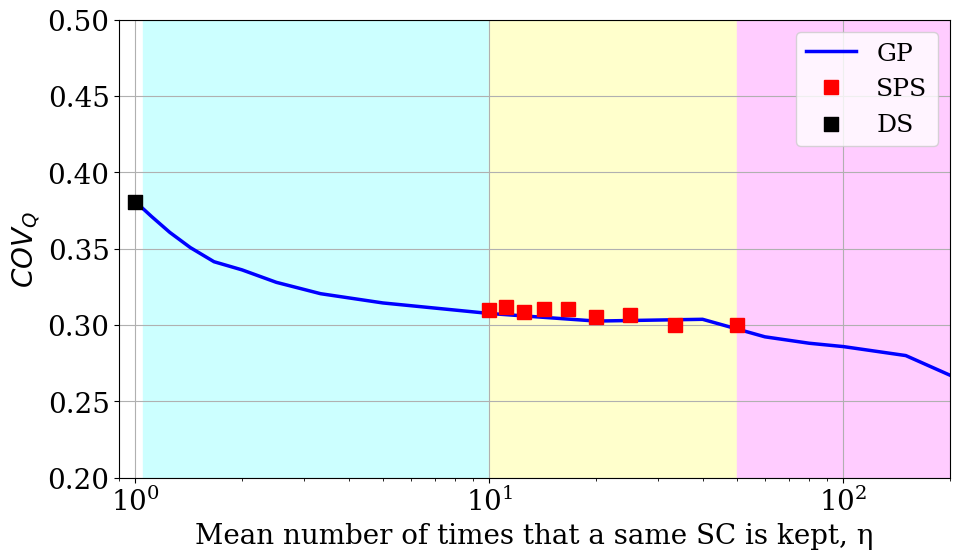

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

density = 700

# Загрузка данных
df = pd.read_csv(f'pp/{density}_mean_COV_time.csv', names=['RC', 'pkeep', 'mean_reuse', 'std_reuse', 'COV', 'eta'])

# Фильтрация данных
df_rc515 = df[df['RC'] == 515]
df_rc1 = df[df['RC'] == 1]

# Настройки визуализации
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 18

# График среднего и стандартного отклонения (область)
plt.figure(figsize=(10, 6))
plt.plot(df_rc515['eta'], df_rc515['mean_reuse'], label='Mean Standard SPS', color='red', marker='s', linestyle='none', markersize=10, zorder=5)
plt.fill_between(df_rc515['eta'], df_rc515['mean_reuse'] - df_rc515['std_reuse'], df_rc515['mean_reuse'] + df_rc515['std_reuse'], 
                 color='magenta', alpha=0.2, label='Std Standard SPS')

plt.plot(df_rc1['eta'], df_rc1['mean_reuse'], label='Mean Geometric SPS', color='blue', linestyle='-', lw=2.5)
plt.fill_between(df_rc1['eta'], df_rc1['mean_reuse'] - df_rc1['std_reuse'], df_rc1['mean_reuse'] + df_rc1['std_reuse'], 
                 color='blue', alpha=0.2, label='Std Geometric SPS')

x_val = 1
y_val = df_rc1[df_rc1['pkeep'] == 0.00]['mean_reuse'].values[0]
std_y = df_rc1[df_rc1['pkeep'] == 0.00]['std_reuse'].values[0]
plt.errorbar(x_val, y_val, yerr=std_y, fmt='s', color='black', markersize=10, label='Standard DS with Std', zorder=6)


# Выделение областей

plt.xlabel('Mean number of times that a same SC is kept, η')
plt.ylabel(r'E($N_{sameSC}$)' + ' and ' + r'std($N_{sameSC}$)')
plt.legend(loc='best', ncols=2)
plt.grid(True)
plt.ylim(0, 14)
plt.xscale('log')
plt.xlim(0.9, 200)
plt.tight_layout()
plt.savefig(f"figures/{density}_mean_std_N_SC_time_vs_eta.png", format='png')
plt.show()

# График COV
plt.figure(figsize=(10, 6))
# Настройки визуализации
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.plot(df_rc1['eta'], df_rc1['COV'], label='GP', color='blue', lw=2.5)
plt.plot(df_rc515['eta'], df_rc515['COV'], label='SPS', color='red', marker='s', markersize=10, lw=2.5, linestyle='none')
plt.scatter(1, df_rc1[df_rc1['pkeep'] == 0.00]['COV'], color='black', s=100, zorder=5, label='DS', marker="s")

# Выделение областей
plt.axvspan(1.05, 10, color='#CCFFFF', label='')     # Зеленая область
plt.axvspan(10, 50, color='#FFFFCC', label='')      # Голубая область
plt.axvspan(50, 200, color='#FFCCFF', label='')     # Персиковая область

plt.xlabel('Mean number of times that a same SC is kept, η')
plt.ylabel(r'$COV_{Q}$')
plt.legend(loc='upper right')
plt.xscale('log')
plt.grid(True)
plt.xlim(0.9, 200)
plt.ylim(0.2, 0.5)
plt.tight_layout()
plt.savefig(f"figures/{density}_COV_N_SC_time_vs_eta.eps", format='eps')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
import os
from itertools import combinations

def fill_all_gaps(df):
    df['int_div_10_24'] = (df['time'] // 10.24).astype(int)
    df['diffF'] = df['nextF'] - df['timeF']
    df.loc[df['diffF'] < 0, 'diffF'] += 1024
    df['nextF'] = df['int_div_10_24'] * 1024 + df['nextF']
    df['timeF'] = df['int_div_10_24'] * 1024 + df['timeF']

    new_rows = []
    for node_id, group in df.groupby('nodeID'):
        group = group.sort_values(by='timeF')
        raw_f_list = group['timeF'].tolist()
        raw_f_list.append(10100)
        for i in range(len(raw_f_list) - 1):
            df_filtered = group[group['timeF'] == raw_f_list[i]]
            for row_time in range(int(raw_f_list[i] + 10), int(raw_f_list[i + 1]), 10):
                new_rows.append({
                    'nodeID': node_id,
                    'time': df_filtered['time'].values[0],
                    'timeF': row_time,
                    'timeSF': df_filtered['timeSF'].values[0],
                    'RC': -1,
                    'nextF': df_filtered['diffF'].values[0] + row_time,
                    'nextSF': df_filtered['nextSF'].values[0],
                    'int_div_10_24': -1
                })
    return pd.concat([df, pd.DataFrame(new_rows)], ignore_index=True).sort_values(by=['nodeID', 'timeF'])

def process_parameter(var_parameter, RC, density):
    # Read and process main data file
    df = pd.read_csv(
        f'n{density}/baoicchi_mob_veh_{density}_pKeep_{var_parameter}_ReEval1_RC{RC}/SSPSlog.txt',
        names=["nodeID", "time", "timeF", "timeSF", "RC", "nextF", "nextSF"],
        usecols=[0, 1, 2, 3, 9, 16, 17]
    )
    df_extended = fill_all_gaps(df)

    # Read and merge positions
    df_pos = pd.read_csv(
        f'n{density}/baoicchi_mob_veh_{density}_pKeep_{var_parameter}_ReEval1_RC{RC}/LogPOS.txt',
        names=['nodeID', 'X', 'Y'], usecols=[0, 1, 2], dtype={'nodeID': int, 'X': float, 'Y': int}
    ).drop_duplicates(subset='nodeID').sort_values(by='nodeID')

    df_pos['nodeID'] += 1
    merged_df = pd.merge(df_extended, df_pos, on='nodeID', how='left')

    df_filtered = merged_df[(merged_df['timeF'] > 1024) & (merged_df['timeF'] < 10100)]

    # Group and calculate distances
    IVD = []
    
    for (frame, subframe), sub_group in df_filtered.groupby(['nextF', 'nextSF']):
        if len(sub_group) < 2:
            continue
        x_distances = np.diff(np.sort(sub_group['X'].values))
        IVD.append({'frame': frame, 'subframe': subframe, 'IVD': x_distances, 'pkeep': var_parameter, 'SC': subframe + (frame % 10) * 10, "N": len(sub_group), 'RC':RC})
    
    df_IVD= pd.DataFrame(IVD)
    df_IVD.to_csv(f'pp/{density}_PDF.csv', mode='a', header=False, index=False)
    return pd.DataFrame(IVD)

def calculate_cov(df_IVD, RC, var_parameter, density):
    COV_list = []
    for sc in range(1, 101):
        df_IVD_SC = df_IVD[df_IVD['SC'] == sc]
        yv = np.hstack(df_IVD_SC['IVD'].values)
        if len(yv) == 0:
            continue
        mean_reuse = yv.mean()
        mean_N = df_IVD_SC["N"].mean()
        std_reuse = yv.std()
        COV = std_reuse / mean_reuse
        COV_list.append({'RC': RC, 'pkeep': var_parameter, 'mean_reuse': mean_reuse, 'std_reuse': std_reuse, 'COV': COV, 'SC': sc, 'N': mean_N, 'density': density})
    return pd.DataFrame(COV_list)

# Parallel execution
RC = 1

density = 700
# Range of parameter values to process
parameter_range = ['0.000000', '0.100000', '0.200000', '0.300000', '0.400000', '0.500000', '0.600000', '0.700000', '0.800000', '0.900000', '0.950000','0.975000','0.983333','0.987500','0.990000','0.993333','0.995000']
#parameter_range = ['0.000000', '0.100000', '0.200000', '0.300000', '0.400000', '0.500000', '0.600000', '0.700000', '0.800000']


results = Parallel(n_jobs=-1)(delayed(process_parameter)(param, RC, density) for param in parameter_range)


# Post-process and calculate COV for all parameters
COV_results = Parallel(n_jobs=-1)(delayed(calculate_cov)(df_IVD, RC, param, density) for df_IVD, param in zip(results, parameter_range))

# Save COV data
df_COV = pd.concat(COV_results, ignore_index=True)
df_COV.to_csv(f'pp/{density}_COV_space_order_SC_d.csv', mode='a', header=False, index=False)



In [22]:
df_COV.to_csv(f'pp/{density}_COV_space_order_SC_d.csv', mode='a', header=False, index=False)

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

parameter_range = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975, 0.983333, 0.987500, 0.99, 0.993333, 0.995000] #for RC=1
#parameter_range = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80] #for RC=515

COV_list = []

mean_SC_list = []

density = 700

RC=1

df_space_order_raw = pd.read_csv(f'pp/{density}_COV_space_order_SC_d.csv', names=['RC', 'pkeep', 'mean_reuse', 'std_reuse', 'COV', 'SC', "N", 'density'])

COV_df = df_space_order_raw[df_space_order_raw['RC'] == RC]


for var_parameter in parameter_range:

    mean_D = COV_df[COV_df['pkeep']==var_parameter]['mean_reuse'].mean()
    mean_std = COV_df[COV_df['pkeep']==var_parameter]['std_reuse'].mean()
    mean_COV = COV_df[COV_df['pkeep']==var_parameter]['COV'].mean()
    if RC == 515:
        eta = 10/(1-var_parameter)
    else:
        eta = 1/(1-var_parameter)
    mean_SC_list.append({'RC': RC, 'pkeep': var_parameter, 'mean_reuse_distance': mean_D, 'std_reuse_distance': mean_std, 'COV': mean_COV, 'eta': eta})


mean_COV_df = pd.DataFrame(mean_SC_list)

mean_COV_df.to_csv(f'pp/{density}_mean_COV_space_d.csv', mode='a', header=False, index=False)

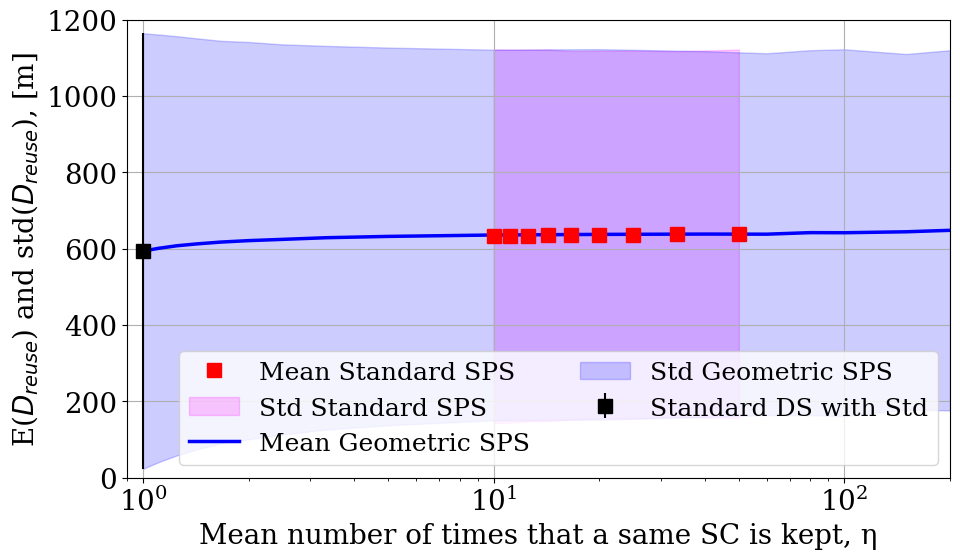

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


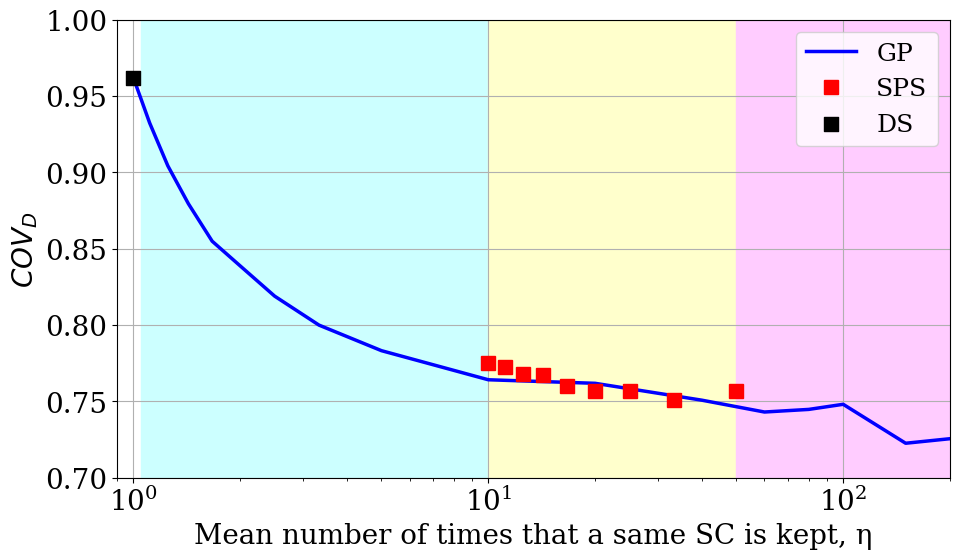

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

density = 700

# Загрузка данных
df = pd.read_csv(f'pp/{density}_mean_COV_space_d.csv', names=['RC', 'pkeep', 'mean_reuse', 'std_reuse', 'COV', 'eta'])

# Фильтрация данных
df_rc515 = df[df['RC'] == 515]
df_rc1 = df[df['RC'] == 1]

# Настройки визуализации
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 18

plt.figure(figsize=(10, 6))
plt.plot(df_rc515['eta'], df_rc515['mean_reuse'], label='Mean Standard SPS', color='red', marker='s', linestyle='none', markersize=10, zorder=5)
plt.fill_between(df_rc515['eta'], df_rc515['mean_reuse'] - df_rc515['std_reuse'], df_rc515['mean_reuse'] + df_rc515['std_reuse'], 
                 color='magenta', alpha=0.2, label='Std Standard SPS')

plt.plot(df_rc1['eta'], df_rc1['mean_reuse'], label='Mean Geometric SPS', color='blue', linestyle='-', lw=2.5)
plt.fill_between(df_rc1['eta'], df_rc1['mean_reuse'] - df_rc1['std_reuse'], df_rc1['mean_reuse'] + df_rc1['std_reuse'], 
                 color='blue', alpha=0.2, label='Std Geometric SPS')

x_val = 1
y_val = df_rc1[df_rc1['pkeep'] == 0.00]['mean_reuse'].values[0]
std_y = df_rc1[df_rc1['pkeep'] == 0.00]['std_reuse'].values[0]
plt.errorbar(x_val, y_val, yerr=std_y, fmt='s', color='black', markersize=10, label='Standard DS with Std', zorder=6)



plt.xlabel('Mean number of times that a same SC is kept, η')
plt.ylabel(r'E($D_{reuse}$)' + ' and ' + r'std($D_{reuse}$)' + ', [m]')
plt.legend(loc='best', ncols=2)
plt.grid(True)
plt.ylim(0, 1200)
plt.xscale('log')
plt.xlim(0.9, 200)
plt.tight_layout()
plt.savefig(f"figures/{density}_mean_std_Dreuse_vs_eta.png", format='png')
plt.show()

# График COV
plt.figure(figsize=(10, 6))
# Настройки визуализации
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 18
plt.plot(df_rc1['eta'], df_rc1['COV'], label='GP', color='blue', lw=2.5)
plt.plot(df_rc515['eta'], df_rc515['COV'], label='SPS', color='red', marker='s', markersize=10, lw=2.5, linestyle='none')
plt.scatter(1, df_rc1[df_rc1['pkeep'] == 0.00]['COV'], color='black', s=100, zorder=5, label='DS', marker="s")

# Выделение областей
plt.axvspan(1.05, 10, color='#CCFFFF', label='')     # Зеленая область
plt.axvspan(10, 50, color='#FFFFCC', label='')      # Голубая область
plt.axvspan(50, 200, color='#FFCCFF', label='')     # Персиковая область

plt.xlabel('Mean number of times that a same SC is kept, η')
plt.ylabel(r'$COV_{D}$')
plt.legend(loc='upper right')
plt.xscale('log')
plt.grid(True)
plt.xlim(0.9, 200)
plt.ylim(0.7, 1)
plt.tight_layout()
plt.savefig(f"figures/{density}_COV_Dreuse_vs_eta.eps", format='eps')
plt.show()
